# Jewels and Stones

*Michel Wermelinger*, 23 January 2024, last updated 13 March 2024

In this example [algorithmic essay](https://dsa-ou.github.io/algoesup) I will tackle LeetCode problem [Jewels and Stones](https://leetcode.com/problems/jewels-and-stones/).
The inputs are two strings _jewels_ and _stones_, where each character represents a type of stone, 
e.g. `A` for amethyst, `D` for diamond, `b` for basalt and `?` for an unknown stone.
The _jewels_ string contains the characters that represent jewels, without repetition. 
The desired output is the number of stones that are jewels. 
For example, if _jewels_ is `"AD"` and _stones_ is `"b?AbDAb"` then the output is 3 
because three of the stones are jewels (two amethysts and one diamond).
To be clear, which stones and jewels the characters represent doesn't really matter:
the output is simply how many characters of the second string occur in the first string.

This essay will illustrate a **space-time trade-off**: 
by using an additional data structure, we get a faster algorithm.
I assume you're familiar with sets, bags (multisets) and basic complexity analysis.
This essay uses Big-Theta notation Θ(...), but if you're not familiar with it,
you can read it as Big-Oh notation O(...) for the purposes of the analyses done below.
Sorting, binary search, and log-linear and logarithmic complexities are mentioned in Section 2.3, 
but you can skip it, as it won't affect the understanding of the rest of the essay.

Before starting to solve the problem, I import the necessary functions from `algoesup`,
the algorithmic essays support library, and turn on the tools that will check my code
for style and type violations (with [Ruff](https://astral.sh/ruff) and [pytype](https://google.github.io/pytype)), and 
for constructs I didn't teach (with [allowed](https://dsa-ou.github.io/allowed)).

In [1]:
import os

if 'COLAB_GPU' in os.environ:  # if we are in Google Colab...
    !pip install algoesup --no-deps
    !pip install allowed ruff pytype

In [2]:
from algoesup import test, time_cases, time_functions

In [3]:
%load_ext algoesup.magics
%ruff on
%pytype on
%allowed on

ruff was activated
pytype was activated
allowed was activated


## 1 Tests

Before thinking of any solution, I write down some tests. Each test is two input strings and the expected integer output. 
I need to think of **edge cases**: inputs that are extreme values or that lead to extreme outputs.

For this problem, one edge case is that none of the stones is a jewel, which can happen in several ways: 
there are no stones; there are no jewels; there are stones and jewels but no character in _stones_ occurs in _jewels_. 
Note that the problem statement doesn't prevent the strings to be empty, so we must assume they may be. 

Another edge case is that all stones are jewels, which again can happen in several ways: 
the two input strings are the same; all stones are the same jewel; each stone is a jewel but not all jewels are among the stones.

Besides the edge cases I must also consider normal cases, where the stones include jewels and non-jewels 
and where the stones don't appear in the same order as the jewels.

I write the tests succinctly as a table, with one row per test, and one column with a string describing the test, 
one column per input, and a final column with the expected output. 
Later, I will use a function from `algoesup` to run all the tests and report those
where the actual outputs differ from the expected ones.

In [4]:
# don't allow code formatters to change this table
# fmt: off
tests = [
    # case                  jewels  stones  output
    ("no jewels",           "",     "abc",      0),
    ("no stones",           "DA",   "",         0),
    ("both empty",          "",     "",         0),
    ("none is a jewel",     "DA",   "dada?",    0),
    ("equal strings",       "DA",   "DA",       2),
    ("all same jewel",      "DA",   "AAAA",     4),
    ("some jewels missing", "DARJ", "RRD",      3),
    ("some not jewels",     "RAD",  "bRADAb",   4),
]
# allow code formatters to change the following cells
# fmt: on

## 2 Algorithms
Next I think of possible algorithms and their complexity, to decide which ones are worth implementing.

### 2.1 Without additional data
I first attempt to solve the problem directly on the input strings.
One approach that comes to mind is to count how often each jewel occurs among the stones.

> **Algorithm 1**:
> Set a counter to zero. For each jewel, iterate over the stones.
> If a stone is the same as the current jewel, increment the counter.
> After going through all jewels, return the counter.

If *j* is the number of jewels and *s* the number of stones, then this algorithm always
has complexity *j* × Θ(*s*) = Θ(*j* × *s*) because it does at most two constant-time operations,
checking equality and incrementing the counter, for each jewel and stone.

The first approach searches each jewel among the stones. 
The symmetric approach is to search each stone among the jewels:

> **Algorithm 2**:
> Set a counter to zero. For each stone, do a linear search for it among the jewels.
> If it is found, increment the counter.
> After going through all stones, return the counter.

In the best case, each stone is the first jewel, and the search takes constant time.
The best-case complexity is *s* × Θ(1) = Θ(*s*).
In the worst case, the search goes through all the jewels, because the stone isn't a jewel
or is the last jewel. The worst-case complexity is *s* × Θ(*j*) = Θ(*s* × *j*).

### 2.2 With additional data
My next attempts consider pre-processing the inputs to make the searches faster.

Algorithm 1 goes through the stones *j* times, each time counting how often a jewel occurs.
It's more efficient to go through the stones only once, 
counting how often each stone occurs, and then add the counts of those that are jewels.
We need to know the frequency of each stone and the natural data type for that is the bag (or multiset).

> **Algorithm 3**:
> Put all stones in a bag. Initialise a counter to zero.
> For each jewel, add to the counter the frequency of that jewel in the bag.
> Return the value of the counter.

If the bag type is implemented efficiently, both adding an item and obtaining its frequency take constant time.
The complexity of Algorithm 3 is thus *s* × Θ(1) + *j* × Θ(1) = Θ(*s* + *j*).

Algorithm 2 checks if each stone is a jewel.
Is there an abstract data type (ADT) that provides such an operation?
Yes, the set ADT allows checking if an item is a member of a set, which leads to...

> **Algorithm 4**:
> Put all jewels in a set. Initialise a counter to zero.
> For each stone, if it is a member of the set, increment the counter.
> Return the value of the counter.

If the set ADT is implemented efficiently, both adding an item and checking membership take constant time.
The complexity of Algorithm 4 is thus *j* × Θ(1) + *s* × Θ(1) = Θ(*j* + *s*).

### 2.3 With sorting
The order of jewels and stones in the input strings doesn't affect the output (the number of stones that are jewels). 
I can thus sort the jewels, the stones, or both, to use logarithmic binary search instead of linear search.

However, sorting takes linear time in the best case and log-linear or quadratic time in the worst case.
I already have algorithms that are linear in the total size of the input, so sorting wouldn't be more efficient.
I therefore do not further pursue this approach.

### 2.4 Summary
Algorithms 1 and 2 don't use additional memory, but have complexity Θ(*j* × *s*),
while Algorithms 3 and 4 have better complexity Θ(*j* + *s*), 
but have the run-time and memory overhead of an additional data structure.
In practice, Algorithms 3 and 4 might be slower than Algorithms 1 and 2, so it's best to implement all of them.

However, Algorithm 1 *always* takes Θ(*j* × *s*) whereas Algorithm 2 only does so in the worst case.
I therefore won't implement Algorithm 1.

Algorithm 3 creates a set with *j* jewels, whereas Algorithm 4 creates a bag with *s* stones.
Typically, we expect inputs to have more stones than jewels (*j* < *s*), so Algorithm 3 is likely to be faster.
Nevertheless, I'll implement Algorithm 4 too, for comparison.

## 3 Code
The next function implements Algorithm 2, using Python's `in` operator to do the linear search.

In [5]:
def count_in_string(jewels: str, stones: str) -> int:
    """Return the number of characters in `stones` that are in `jewels`.

    Use Algorithm 2: for each stone, check if it's a jewel.
    Complexity: best Θ(len(stones)); worst Θ(len(stones) * len(jewels))
    """
    counter = 0
    for stone in stones:
        if stone in jewels:
            counter = counter + 1
    return counter


# test(function, test_table) runs `function` on each test in `test_table`
# and prints the tests that fail (actual output isn't the expected output).
test(count_in_string, tests)

Testing count_in_string...
Tests finished: 8 passed (100%), 0 failed.


The implementation of Algorithm 2 passes all tests.
Next, Algorithm 3 can be implemented with Python's [`Counter` class](https://docs.python.org/3/library/collections.html#collections.Counter).

In [6]:
from collections import Counter


def count_in_bag(jewels: str, stones: str) -> int:
    """Return the number of characters in `stones` that are in `jewels`.

    Use Algorithm 3: put stones in a bag; add the frequencies of those that are jewels.
    Complexity: Θ(len(stones) + len(jewels))
    """
    bag = Counter(stones)
    counter = 0
    for jewel in jewels:
        counter = counter + bag[jewel]
    return counter


test(count_in_bag, tests)

Testing count_in_bag...
Tests finished: 8 passed (100%), 0 failed.


Finally, Algorithm 4 can be implemented with Python's built-in [`set` type](https://docs.python.org/3/library/stdtypes.html#set).

In [7]:
def count_in_set(jewels: str, stones: str) -> int:
    """Return the number of characters in `stones` that are in `jewels`.

    Use Algorithm 4: put jewels in a set; count the stones that are in the set.
    Complexity: Θ(len(jewels) + len(stones))
    """
    jewel_set = set(jewels)
    counter = 0
    for stone in stones:
        if stone in jewel_set:
            counter = counter + 1
    return counter


test(count_in_set, tests)

Testing count_in_set...
Tests finished: 8 passed (100%), 0 failed.


## 4 Performance

Finally, I will measure the run-times of the above functions with the `algoesup` library.
The library expects us to define functions that construct inputs for a given total size.

### 4.1 Generating inputs
This problem has two inputs, so I must decide how to divide the total size among both strings.
I'll divide it equally: *s* = *j*. (For odd *n*, *s* = *j* + 1.)
In that way, the expected run-times will be linear or quadratic in *s*:
Θ(*s* + *j*) = Θ(2*s*) = Θ(*s*) or Θ(*s* × *j*) = Θ(*s*²).
This makes it easy to check them empirically.

I write a function to generate a best-case input: each stone is the first jewel.
To generate the input strings, I use Python's built-in `chr` function to obtain a character, given its Unicode number.
The first 31 characters are mostly unprintable control characters, so I start at code 32 (space character).

In [8]:
def best_case(size: int) -> tuple[str, str]:
    """Return a best-case input (pair of strings) of the given size.

    Output: (jewels, stones) with
    - len(jewels) + len(stones) == size, with each string half the size
    - jewels has no duplicate characters
    - all stones are jewels[0]
    """
    j = size // 2
    s = size - j
    # create a string with j different characters (Unicode 32 onwards)
    jewels = ""
    for code in range(32, 32 + j):
        jewels = jewels + chr(code)
    # create a string with s spaces (Unicode 32), the first character in jewels
    stones = " " * s
    return (jewels, stones)

**allowed** found issues:

- 14: chr()

Note that the `allowed` tool reports that I haven't taught my students the `chr` function.
That's why I explained it before presenting the code.

Moving on, I write some tests, to check that `best_case` is generating the right strings.

In [9]:
# fmt: off
test(best_case, [
    # case,           size, (jewels, stones)
    ("empty strings", 0,    ("",     "")),
    ("no jewels",     1,    ("",     " ")),
    ("odd size",      5,    (' !',   "   ")),
])
# fmt: on

Testing best_case...
Tests finished: 3 passed (100%), 0 failed.


To generate a worst case, I have two options: 
no stone is a jewel or all stones are the last jewel (Unicode 31 + *j*).
I choose the first one. (Spoiler alert: I made the wrong choice. Can you see why?)

In [10]:
def worst_case(size: int) -> tuple[str, str]:
    """Return a worst-case input (pair of strings) of the given size.

    Output: (jewels, stones) with
    - len(jewels) + len(stones) == size, with each string half the size
    - jewels has no duplicate characters
    - no stone is a jewel
    """
    j = size // 2
    s = size - j
    # create a string with j different characters (Unicode 32 onwards)
    jewels = ""
    for code in range(32, 32 + j):
        jewels = jewels + chr(code)  # allowed
    # create a string with s different characters (Unicode 32+j onwards)
    stones = ""
    for code in range(32 + j, 32 + j + s):
        stones = stones + chr(code)  # allowed
    return (jewels, stones)


# fmt: off
test(worst_case, [
    # case,           size, (jewels,    stones)
    ("empty strings", 0,    ("",        "")),
    ("no jewels",     1,    ("",        " ")),
    ("odd size",      11,   (' !"#$',   "%&'()*")),  # 5 jewels, 6 stones
])
# fmt: on

Testing worst_case...
Tests finished: 3 passed (100%), 0 failed.


The `# allowed` comment in lines 14 and 18 tells the tool that `chr()` is allowed,
because it was explained, and hence should not be reported.

Finally I generate random typical cases in which not all stones are jewels and not all jewels occur in the stones.

In [11]:
import random


def normal_case(size: int) -> tuple[str, str]:
    """Return a typical input (pair of strings) of the given size.

    Output: (jewels, stones) with
    - len(jewels) + len(stones) == size, with each string half the size
    - jewels has no duplicate characters
    - stones has some jewels and some non-jewels, if len(jewels) > 1
    - not all jewels occur in stones, if len(jewels) > 1
    """
    j = size // 2
    s = size - j
    # create a string with j different characters (Unicode 32 onwards)
    jewels = ""
    for code in range(32, 32 + j):
        jewels = jewels + chr(code)  # allowed
    # create a string with s random characters from Unicode 33 to 33 + 2j
    stones = ""
    for _ in range(s):
        stones = stones + chr(random.randint(33, 33 + 2 * j))  # allowed
    return (jewels, stones)


# Can't test with a test table, because the output is random.
(jewels, stones) = normal_case(20)
counter = count_in_string(jewels, stones)
print("Some stones are jewels:", counter > 0)
print("Some stones aren't jewels:", counter < len(stones))

Some stones are jewels: True
Some stones aren't jewels: True


The loop variable's name is just an underscore (line 21) to avoid a warning that
the loop variable isn't used in the loop's body.

### 4.2 Best, normal and worst run-times
Algorithms 3 and 4 always have the same complexity, but not so for Algorithm 2.
I can measure its run-times on best, typical and worst cases, using the library's `time_cases`.
I start with an input size of 10 and double it four times to 20, 40, 80 and 160.

In [12]:
cases = [best_case, normal_case, worst_case]
time_cases(count_in_string, cases, start=10, double=4)

Run-times for count_in_string

Input size       best_case     normal_case      worst_case 
        10           205.3           182.7           157.2 ns
        20           336.1           332.6           301.2 ns
        40           601.2           497.5           428.7 ns
        80          1104.1          1089.1           783.6 ns
       160          2092.7          2132.6          1553.6 ns

The results are baffling: the worst case is the fastest! 

The linear search is done with the `in` operator, which is much faster than implementing the search in Python.
Due to the very small input sizes, with at most 80 jewels and 80 stones, it doesn't really matter 
whether the search stops at the first jewel or goes through all the jewels.

Since the search takes about the same time in the best and worst cases,
what makes the difference to the overall run-time is how often the counter is updated.
In the best case (all stones are the first jewel) the counter is *always* incremented, 
whereas in the worst case (no stone is a jewel) the counter is *never* incremented.
Hence, the worst case is faster than the best case.

The real issue is that I'm **not generating worst cases**.
I'm not constructing inputs that make Algorithm 2 do the most work. A worst case should 
make the linear search go through all the jewels *and* increment the counter for each one.
The worst case is actually when all stones are the last jewel.

I should go back, modify the `worst_case` function so that `stones = chr(31 + j) * s`, 
and run again the previous cell. Instead, I will run `count_in_string` on larger inputs.
That will avoid the search taking about the same time whether a stone is the first jewel or not a jewel.
This time I also ask for a graphical output.

Run-times for count_in_string

Input size       best_case     normal_case      worst_case 
      1000            14.6            34.7            33.4 µs
      2000            30.4           107.0           115.6 µs
      4000            61.8           336.0           379.9 µs
      8000           125.4          1108.2          1364.0 µs
     16000           249.9          3931.1          5059.0 µs

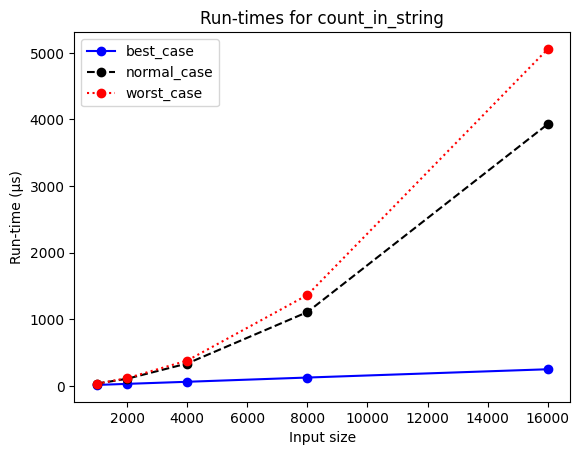

In [13]:
time_cases(count_in_string, cases, start=1000, double=4, chart=True)

The best-case run-times double as the input size doubles, confirming the linear complexity.
The worst-case run-times about quadruple as the input size doubles, confirming the quadratic complexity.

## 4.3 Fastest and slowest algorithm
The library provides `time_functions` to measure the run-times of up to 6 functions on the same inputs.
I run the three implemented algorithms on typical inputs, with the same sizes as before.

Inputs generated by normal_case

Input size count_in_string    count_in_set    count_in_bag 
      1000            35.2            36.7            66.3 µs
      2000           107.9            88.3           144.8 µs
      4000           335.5           187.1           306.1 µs
      8000          1097.5           409.1           630.7 µs
     16000          3998.9           848.5          1298.0 µs

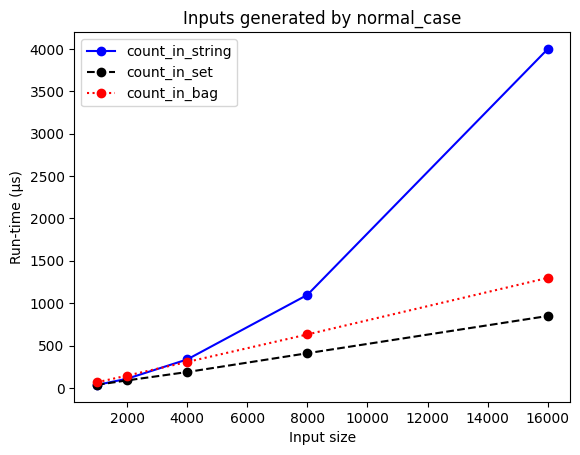

In [14]:
algorithms = [count_in_string, count_in_set, count_in_bag]
time_functions(algorithms, normal_case, 1000, 4, chart=True)

As expected, using a set or bag pays off as the input size increases:
as there are more jewels and stones, the linear search takes longer,
but looking up a stone in a set of jewels or a jewel in a bag of stones takes constant time.
However, for small inputs, a linear search is fast and hence 
the extra time to create the additional data structure doesn't pay off.

Using a set of jewels is about twice as fast as using a bag of stones, maybe because
`set` is built-in and implemented in C, a very fast language, whereas
`Counter` is part of the standard library implemented in Python, which is much slower.
This example shows that algorithms with the same complexity can perform differently in practice, 
because the complexity tells us how the run-times grow, but not how fast or slow they are.

## 5 Concluding remarks
This essay explored a simple problem: how many of the characters in a string occur in another string?
There are at least 7 algorithms: 2 don't require any additional data structure,
2 use a set or a bag to achieve constant-time searches, and 3 other sort one or both inputs.
Three of the first four algorithms were implemented in Python and their run-times measured.
Using a set is the best option: the complexity is the lowest possible (linear in the total size of the inputs),
and the run-times are better than using a bag.